<a href="https://colab.research.google.com/github/pniedzwiedzinski/COVID-19/blob/master/COVID_19_Poland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19

As I'm writing this, there are 25 confirmed infections of the Coronavirus in Poland in span of a week. In this notebook I wrote couple of simulation that would show how fast the epidemic could spread. 

In [1]:
# Public dataset of contagions grouped by countries
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 12651 (delta 70), reused 122 (delta 42), pack-reused 12500
Receiving objects: 100% (12651/12651), 40.51 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (6045/6045), done.


In [0]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

In [3]:
# Load and prepare data

d = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", index_col="Country/Region")
dataset = d.filter(like="Poland", axis=0)

# Remove empty months
# TODO: Fix regex to include months with '2 digits'
dataset = dataset.filter(regex="[3-9]\/\d+\/\d+")
dataset.head()

,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20
Country/Region,,,,,,,,,,
Poland,0,0,0,1,1,5,5,11,16,22


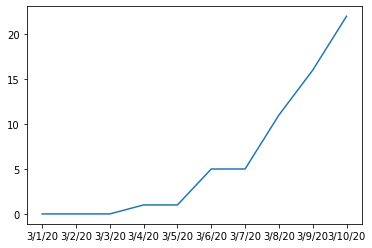

In [4]:
import matplotlib.pyplot as plt

dline = (dataset.columns, dataset.values[0])

fig, ax = plt.subplots()
ax.plot(*dline)

## Exponential growth

The growth of infected people is not static. As more are infected the more people are getting contagious. That's why the growth is exponential. Let's test this theory.

[1, 1.4, 1.9599999999999997, 2.7439999999999993, 3.841599999999999, 5.378239999999998, 7.529535999999997, 10.541350399999995, 14.757890559999993, 20.66104678399999]


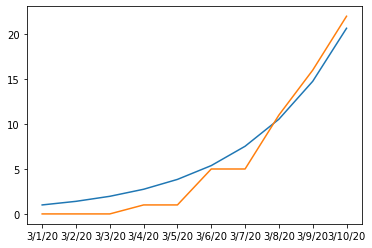

In [5]:
def exponential_line_generator(length: int, growth: float = 1.4):
  x = 1
  yield x
  for _ in range(length):
    x *= growth
    yield x

line = list(exponential_line_generator(len(dataset.columns) - 1))
print(line)

fig, ax = plt.subplots()
ax.plot(line)
ax.plot(*dline)

That looks convincing.

### Is it really exponential growth?
If you are from far future you might get different results. In nature exponential growth is extremely rare. In our example the number of new infections might drop down due to discovery of the cure (or in bad scenario that all the human population is infected).

In my example I multiplied the previous result by static growth factor, but in real life this factor would change over time. As I'm writing this I found that factor `1.4` matches our data the best. But over time this factor would decrease (hopefully). 

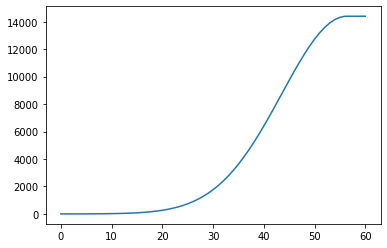

In [6]:
def infection_simulation(length: int, growth: float = 1.4, rate: float = 0.994, min_growth: float = 1.0):
  x = 1
  yield x
  for _ in range(length):
    x *= growth
    growth = max(min_growth, growth*rate) # For now, we want to show the total infected, without the 'cured'
    yield x

line = list(infection_simulation(60))

fig, ax = plt.subplots()
ax.plot(line)

So in our example the epidemic will stop spreading after 60 days with total number of infected at over 14000.

### For those from the future

You could try to tweak the parameters to match the real data.

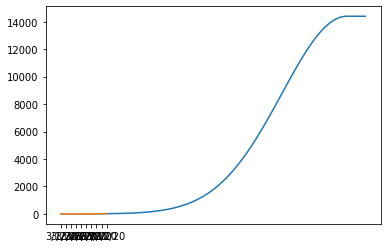

In [7]:
# Play with these:
RATE = 0.994 # 1 - no progress, the smaller the faster the disease will be stoped
GROWTH = 1.4 # The bigger the faster the virus will spread
DAYS = 60

line = list(infection_simulation(DAYS, GROWTH, RATE))
_, ax = plt.subplots()
ax.plot(line)
ax.plot(*dline)

# The fun part - Predicting when the epidemic will end

> 11.03.2020 - There is not enough data to predict anything so I am waiting for the data

We can't really predict the end of the epidemic but we can detect if the epidemic slows down.


### Comparing to exponential

So the first idea could be to compare it to the exponential growth. We could plot both of this line and where the "true" starts to skew from the exponential line.

> NOTE: I'm using here `infection_simulation` instead of `exponential_line_generator` since I want to have non-static growth factor



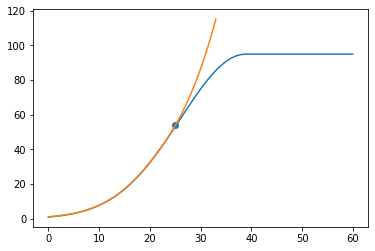

In [8]:
line = list(infection_simulation(60, 1.26, 0.994))

exponential_line = list(infection_simulation(33, 1.26, 0.994, 1.1))

fig, ax = plt.subplots()
ax.plot(line)
ax.plot(exponential_line)
ax.scatter([25], [54])

### Daily increase ratio

Other method to accomplish this could be to compare the increase in number of new infection to the previous day.

So let's suppose this data:

```
[1, 2, 4, 7, 11, 15, 19]
```

The first day there is 1 new infection.
Second day there are 2, third day it's 3, then 4.
But then every next day it's still 4. And this might be actually a good information since that means the growth ratio stopped raising.

So we can calculate the ratio between differnce of newly infected for current day and for the previous day and when the ratio is equal to 1 (like in our example 4 divided by 4) that means that the epidemic has come to its ....  

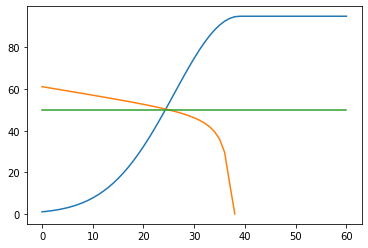

In [9]:
def calculate_ratios(samples: list, _plot_size : int = 50) -> list:
  diffs = []
  ratios = [] 
  prev = None
  for point in samples:
    if prev:
      diff = point - prev
      diffs.append(diff)
      if len(diffs) > 1 and diffs[-2] != 0:
        ratio = diff / diffs[-2]
        ratios.append(ratio * _plot_size)
    prev = point

  return ratios

EPOCHS = 60
line = list(infection_simulation(EPOCHS, 1.26, 0.994))
ratios = calculate_ratios(line)

fig, ax = plt.subplots()
ax.plot(line)
ax.plot(ratios)
ax.plot([i for i in range(len(line))], [50 for _ in range(len(line))])

Let me explain this plot to you, because it might be overwhelming. The blue line is, like previous, the number of infected. The orange line is the ratio between this end previous day and the green line shows the "1" for the orange line. I draw this since I multiplied every ratio by 50 to make it visible on the plot. So in the point where orange line crosses green line the epidemic stops and this should be the same point as in the previous method

## Testing with real data

Tests on data from China and Italy

In [0]:
def predictor(data, _plot_size):
  ratios = calculate_ratios(data, _plot_size)

  fig, ax = plt.subplots()
  ax.plot(data)
  ax.plot(ratios)
  ax.plot([i for i in range(len(line))], [_plot_size for _ in range(len(line))])

In [0]:
def get_data(d, country):
  d = d.filter(like=country, axis=0)
  d_sum = np.array(d.values[1][3:])
  for v in d.values[1:]:
    d_sum += np.array(v[3:])
  return d_sum

In [12]:
dataset_china = get_data(d, "Mainland China")
dataset_china

array([560, 652, 937, 1401, 2070, 2873, 5479, 6029, 8038, 9685, 11742,
       16458, 19497, 23428, 27132, 30236, 33707, 36360, 39337, 41813,
       43809, 44162, 59288, 65730, 67772, 69864, 71772, 73544, 73953,
       74407, 74880, 76332, 76348, 76562, 77071, 77476, 77919, 78244,
       78672, 79249, 79450, 79575, 79699, 79850, 80005, 80088, 80137,
       80173, 80196], dtype=object)

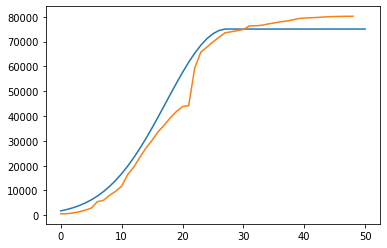

In [13]:
# Compare to "simulated" data

RATE = 0.99 # 1 - no progress, the smaller the faster the disease will be stoped
GROWTH = 1.6 # The bigger the faster the virus will spread
DAYS = 50
SHIFT = 20

dataset_china = get_data(d, "Mainland China")
line = list(infection_simulation(SHIFT+DAYS, GROWTH, RATE))
_, ax = plt.subplots()
ax.plot(line[SHIFT:])
ax.plot(dataset_china)

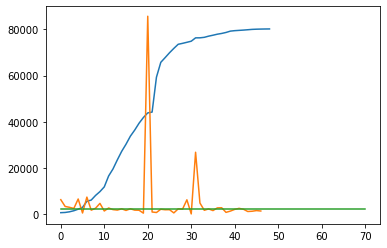

In [14]:
predictor(dataset_china, 2000)

Conclusion: It doesn't seem to work when adding data from the whole country. Or maybe it's just too noisy. Let's try by one region.

#### Test for only one region instead of whole country

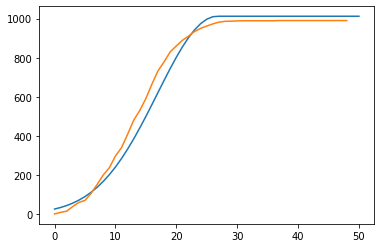

In [15]:
dataset_china = d.filter(like="Mainland China", axis=0)
dataset_china = dataset_china.values[0][3:]

# Compare to "simulated" data
RATE = 0.9898 # 1 - no progress, the smaller the faster the disease will be stoped
GROWTH = 1.45 # The bigger the faster the virus will spread
DAYS = 50
SHIFT = 10

line = list(infection_simulation(SHIFT+DAYS, GROWTH, RATE))
_, ax = plt.subplots()
ax.plot(line[SHIFT:])
ax.plot(dataset_china)

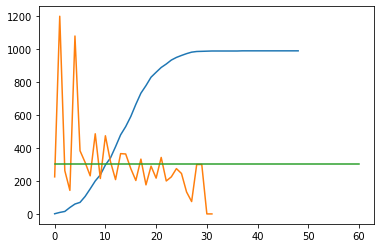

In [16]:
predictor(dataset_china, 300)

Now it looks promising. It's very noisy but we can see that it's now for sure below the green bar. And so the China Government says that the epidemic is under control.